# Zero-Shot Administrative Form Classifier

This notebook implements a zero-shot classifier that identifies administrative forms by comparing page embeddings to reference examples.

## Advantages:
- **No training required** - Works immediately with example forms
- **Fast inference** - Process 190k documents efficiently
- **Easy to update** - Add new examples without retraining
- **Interpretable** - Simple similarity threshold

## Approach:
1. Extract embeddings from all example administrative forms
2. Create a reference representation (mean embedding or keep all)
3. For each page in a document, compute similarity to reference
4. Classify based on similarity threshold

In [101]:
import os
# Set tokenizers parallelism to false to avoid fork warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from pdf2image import convert_from_path
from tqdm import tqdm
import json
import pickle
from typing import List, Dict, Tuple, Optional
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Multiprocessing imports
from multiprocessing import Pool, cpu_count, Queue
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import multiprocessing as mp
from functools import partial
import time

# For different model options
from transformers import (
    DonutProcessor, 
    VisionEncoderDecoderModel,
    CLIPProcessor, 
    CLIPModel,
    AutoImageProcessor, 
    AutoModel
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Available CPU cores: {cpu_count()}")

Using device: cpu
Available CPU cores: 10


In [103]:
import os
# Set tokenizers parallelism to false to avoid fork warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from pdf2image import convert_from_path
from tqdm import tqdm
import json
import pickle
from typing import List, Dict, Tuple, Optional
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# For different model options
from transformers import (
    DonutProcessor, 
    VisionEncoderDecoderModel,
    CLIPProcessor, 
    CLIPModel,
    AutoImageProcessor, 
    AutoModel
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Paths
BASE_PATH = Path('/Users/admin-tascott/Documents/GitHub/chehalis')
EXAMPLE_FORMS_PATH = BASE_PATH / 'data' / 'raw' / '_exampleforms'
NON_EXAMPLES_PATH = BASE_PATH / 'data' / 'raw' / '_nonexamples'

# Model selection
MODEL_TYPE = "clip"  # Options: "donut", "clip", "dinov2"

# Processing parameters
IMAGE_DPI = 150  # Resolution for PDF conversion
BATCH_SIZE = 8   # Batch size for embedding extraction
SIMILARITY_THRESHOLD = 0.85  # Initial threshold (will be tuned)

# Parallel processing parameters
USE_MULTIPROCESSING = True  # Enable multiprocessing
N_WORKERS = cpu_count() - 1  # Leave one core free
MAX_PDFS_PER_WORKER = 100  # PDFs per worker batch

# Output paths
EMBEDDINGS_CACHE_PATH = BASE_PATH / 'code' / 'preprocessing' / 'cached_embeddings'
EMBEDDINGS_CACHE_PATH.mkdir(exist_ok=True)

In [105]:
# Paths
BASE_PATH = Path('/Users/admin-tascott/Documents/GitHub/chehalis')
EXAMPLE_FORMS_PATH = BASE_PATH / 'data' / 'raw' / '_exampleforms'
NON_EXAMPLES_PATH = BASE_PATH / 'data' / 'raw' / '_nonexamples'

# Model selection
MODEL_TYPE = "clip"  # Options: "donut", "clip", "dinov2"

# Processing parameters
IMAGE_DPI = 100  # Resolution for PDF conversion
BATCH_SIZE = 8   # Batch size for embedding extraction
SIMILARITY_THRESHOLD = 0.85  # Initial threshold (will be tuned)

# Output paths
EMBEDDINGS_CACHE_PATH = BASE_PATH / 'code' / 'preprocessing' / 'cached_embeddings'
EMBEDDINGS_CACHE_PATH.mkdir(exist_ok=True)

## 3. Model Loading

In [107]:
def load_model(model_type: str):
    """Load the specified model for embedding extraction"""
    
    if model_type == "donut":
        # Check if fine-tuned model exists
        MODEL_DIR = "./form_classifier_model"
        if os.path.exists(MODEL_DIR):
            print(f"Loading fine-tuned Donut model from {MODEL_DIR}")
            model = VisionEncoderDecoderModel.from_pretrained(MODEL_DIR)
            processor = DonutProcessor.from_pretrained(MODEL_DIR)
        else:
            print("Loading base Donut model")
            model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
            processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
        return model.encoder.to(device), processor
    
    elif model_type == "clip":
        print("Loading CLIP model")
        model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        return model.vision_model.to(device), processor
    
    elif model_type == "dinov2":
        print("Loading DINOv2 model")
        processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
        model = AutoModel.from_pretrained('facebook/dinov2-base')
        return model.to(device), processor
    
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Load the selected model
model, processor = load_model(MODEL_TYPE)
model.eval()  # Set to evaluation mode
print(f"Model loaded successfully")

Loading CLIP model
Model loaded successfully


In [108]:
# Parallel processing functions

def init_worker(model_type_arg):
    """Initialize model in each worker process"""
    global worker_model, worker_processor, worker_model_type
    worker_model_type = model_type_arg
    
    # Each worker loads its own model
    if model_type_arg == "clip":
        model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        worker_model = model.vision_model
    elif model_type_arg == "donut":
        model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
        processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
        worker_model = model.encoder
    elif model_type_arg == "dinov2":
        processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
        model = AutoModel.from_pretrained('facebook/dinov2-base')
        worker_model = model
    
    worker_model.eval()
    worker_processor = processor

def process_pdf_parallel(pdf_path: Path) -> Dict:
    """Process a single PDF in a worker process"""
    global worker_model, worker_processor, worker_model_type
    
    results = {
        'filename': pdf_path.name,
        'path': str(pdf_path),
        'embeddings': [],
        'page_numbers': [],
        'error': None
    }
    
    try:
        # Convert PDF to images
        images = pdf_to_images(pdf_path, dpi=IMAGE_DPI)
        if not images:
            results['error'] = "Failed to convert PDF"
            return results
        
        # Extract embeddings for each page
        for page_num, image in enumerate(images, 1):
            try:
                # Preprocess image
                image = preprocess_image(image, worker_model_type)
                
                # Extract embedding (CPU only in worker)
                with torch.no_grad():
                    if worker_model_type in ["donut", "clip"]:
                        inputs = worker_processor(images=image, return_tensors="pt")
                        outputs = worker_model(**inputs)
                    else:  # dinov2
                        inputs = worker_processor(images=image, return_tensors="pt")
                        outputs = worker_model(**inputs)
                    
                    # Extract embedding
                    if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
                        embedding = outputs.pooler_output
                    elif hasattr(outputs, 'last_hidden_state'):
                        embedding = outputs.last_hidden_state.mean(dim=1)
                    else:
                        embedding = outputs[0].mean(dim=1) if isinstance(outputs, tuple) else outputs.mean(dim=1)
                    
                    embedding = embedding.numpy()[0]
                
                results['embeddings'].append(embedding)
                results['page_numbers'].append(page_num)
                
            except Exception as e:
                print(f"Error processing page {page_num} of {pdf_path.name}: {e}")
        
        results['num_pages'] = len(images)
        
    except Exception as e:
        results['error'] = str(e)
        print(f"Error processing {pdf_path.name}: {e}")
    
    return results

def process_pdfs_parallel(pdf_files: List[Path], 
                         model_type: str,
                         n_workers: int = None,
                         show_progress: bool = True) -> List[Dict]:
    """Process multiple PDFs in parallel using multiprocessing"""
    
    if n_workers is None:
        n_workers = N_WORKERS
    
    print(f"\\nProcessing {len(pdf_files)} PDFs using {n_workers} workers...")
    start_time = time.time()
    
    # Create pool with initializer
    with Pool(n_workers, initializer=init_worker, initargs=(model_type,)) as pool:
        # Process with progress bar
        if show_progress:
            results = list(tqdm(
                pool.imap(process_pdf_parallel, pdf_files),
                total=len(pdf_files),
                desc="Processing PDFs"
            ))
        else:
            results = pool.map(process_pdf_parallel, pdf_files)
    
    elapsed = time.time() - start_time
    print(f"Processed {len(pdf_files)} PDFs in {elapsed:.1f} seconds")
    print(f"Average: {elapsed/len(pdf_files):.2f} seconds per PDF")
    
    return results

def classify_pdf_batch_parallel(pdf_paths: List[Path],
                               reference_embeddings: np.ndarray,
                               reference_prototype: np.ndarray,
                               model_type: str,
                               threshold: float = SIMILARITY_THRESHOLD,
                               use_prototype: bool = True,
                               n_workers: int = None) -> List[Dict]:
    """Classify a batch of PDFs in parallel"""
    
    # First, extract embeddings in parallel
    embedding_results = process_pdfs_parallel(pdf_paths, model_type, n_workers)
    
    # Then classify based on embeddings
    classification_results = []
    
    for result in embedding_results:
        if result['error']:
            classification_results.append({
                'filename': result['filename'],
                'contains_form': False,
                'form_pages': [],
                'page_scores': [],
                'max_similarity': 0.0,
                'error': result['error']
            })
            continue
        
        # Classify each page
        form_pages = []
        page_scores = []
        max_similarity = 0.0
        
        for embedding, page_num in zip(result['embeddings'], result['page_numbers']):
            # Compute similarity
            if use_prototype:
                similarity = compute_similarity_to_prototype(embedding, reference_prototype)
            else:
                similarity = compute_similarity_to_references(embedding, reference_embeddings, method='max')
            
            page_scores.append({
                'page': page_num,
                'similarity': float(similarity)
            })
            
            if similarity >= threshold:
                form_pages.append(page_num)
            
            max_similarity = max(max_similarity, similarity)
        
        classification_results.append({
            'filename': result['filename'],
            'contains_form': len(form_pages) > 0,
            'form_pages': form_pages,
            'page_scores': page_scores,
            'max_similarity': max_similarity,
            'total_pages': result.get('num_pages', len(result['embeddings'])),
            'error': None
        })
    
    return classification_results

# Check if cached embeddings exist
cache_file = EMBEDDINGS_CACHE_PATH / f"{MODEL_TYPE}_reference_embeddings.pkl"

if cache_file.exists():
    print(f"Loading cached reference embeddings from {cache_file}")
    with open(cache_file, 'rb') as f:
        cache_data = pickle.load(f)
        reference_embeddings = cache_data['embeddings']
        reference_metadata = cache_data['metadata']
else:
    print("Building reference embeddings from example forms...")
    pdf_files = list(EXAMPLE_FORMS_PATH.glob('*.pdf'))
    print(f"Processing {len(pdf_files)} example form PDFs")
    
    if USE_MULTIPROCESSING and len(pdf_files) > 10:
        # Use parallel processing for many files
        print("Using parallel processing for reference embeddings...")
        
        # Process PDFs in parallel
        results = process_pdfs_parallel(pdf_files, MODEL_TYPE, N_WORKERS)
        
        # Collect embeddings and metadata
        reference_embeddings = []
        reference_metadata = []
        
        for result in results:
            if result['error']:
                print(f"Skipping {result['filename']} due to error: {result['error']}")
                continue
            
            for embedding, page_num in zip(result['embeddings'], result['page_numbers']):
                reference_embeddings.append(embedding)
                reference_metadata.append({
                    'file_path': result['path'],
                    'filename': result['filename'],
                    'page_num': page_num,
                    'total_pages': result['num_pages']
                })
    else:
        # Use sequential processing for small datasets
        reference_embeddings = []
        reference_metadata = []
        
        for pdf_path in tqdm(pdf_files, desc="Processing example forms"):
            images = pdf_to_images(pdf_path)
            
            if images:
                # Extract embeddings for all pages
                embeddings = extract_embeddings(images, model, processor, MODEL_TYPE)
                
                # Store embeddings and metadata
                for i, embedding in enumerate(embeddings):
                    reference_embeddings.append(embedding)
                    reference_metadata.append({
                        'file_path': str(pdf_path),
                        'filename': pdf_path.name,
                        'page_num': i + 1,
                        'total_pages': len(images)
                    })
    
    reference_embeddings = np.array(reference_embeddings)
    
    # Cache the embeddings
    print(f"Caching reference embeddings to {cache_file}")
    with open(cache_file, 'wb') as f:
        pickle.dump({
            'embeddings': reference_embeddings,
            'metadata': reference_metadata,
            'model_type': MODEL_TYPE
        }, f)

print(f"\nReference set contains {len(reference_embeddings)} form pages")
print(f"Embedding dimension: {reference_embeddings.shape[1]}")

## 4. PDF Processing Functions

In [111]:
def pdf_to_images(pdf_path: Path, dpi: int = IMAGE_DPI) -> List[Image.Image]:
    """Convert PDF to list of PIL Images"""
    try:
        images = convert_from_path(pdf_path, dpi=dpi)
        return images
    except Exception as e:
        print(f"Error converting {pdf_path}: {e}")
        return []

def preprocess_image(image: Image.Image, model_type: str) -> Image.Image:
    """Preprocess image based on model requirements"""
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    if model_type == "donut":
        # Donut expects larger images
        image.thumbnail((1280, 960), Image.Resampling.LANCZOS)
    else:
        # CLIP and DINOv2 work with smaller images
        image.thumbnail((224, 224), Image.Resampling.LANCZOS)
    
    return image

## 5. Embedding Extraction

In [113]:
@torch.no_grad()
def extract_embeddings(images: List[Image.Image], model, processor, model_type: str, 
                      batch_size: int = BATCH_SIZE) -> np.ndarray:
    """Extract embeddings for a list of images"""
    embeddings = []
    
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i+batch_size]
        
        # Preprocess images
        batch_images = [preprocess_image(img, model_type) for img in batch_images]
        
        # Process batch
        if model_type in ["donut", "clip"]:
            inputs = processor(images=batch_images, return_tensors="pt").to(device)
            outputs = model(**inputs)
        else:  # dinov2
            inputs = processor(images=batch_images, return_tensors="pt").to(device)
            outputs = model(**inputs)
        
        # Extract embeddings based on model type
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            batch_embeddings = outputs.pooler_output
        elif hasattr(outputs, 'last_hidden_state'):
            # Mean pool the sequence dimension
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        else:
            batch_embeddings = outputs[0].mean(dim=1)  # Fallback
        
        embeddings.append(batch_embeddings.cpu().numpy())
    
    return np.vstack(embeddings)

@torch.no_grad()
def extract_embedding_single(image: Image.Image, model, processor, model_type: str) -> np.ndarray:
    """Extract embedding for a single image"""
    image = preprocess_image(image, model_type)
    
    if model_type in ["donut", "clip"]:
        inputs = processor(images=image, return_tensors="pt").to(device)
        outputs = model(**inputs)
    else:  # dinov2
        inputs = processor(images=image, return_tensors="pt").to(device)
        outputs = model(**inputs)
    
    # Extract embedding
    if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
        embedding = outputs.pooler_output
    elif hasattr(outputs, 'last_hidden_state'):
        embedding = outputs.last_hidden_state.mean(dim=1)
    else:
        embedding = outputs[0].mean(dim=1)
    
    return embedding.cpu().numpy()[0]

def process_document_folder(folder_path: Path,
                          model,
                          processor,
                          model_type: str,
                          reference_embeddings: np.ndarray,
                          reference_prototype: np.ndarray,
                          threshold: float,
                          output_file: str = 'zero_shot_results.csv',
                          max_files: Optional[int] = None,
                          use_prototype: bool = True,
                          use_parallel: bool = None) -> pd.DataFrame:
    """
    Process all PDFs in a folder using zero-shot classification
    
    Args:
        use_parallel: Use parallel processing (defaults to USE_MULTIPROCESSING setting)
    """
    if use_parallel is None:
        use_parallel = USE_MULTIPROCESSING
    
    results = []
    pdf_files = list(folder_path.glob('*.pdf'))
    
    if max_files:
        pdf_files = pdf_files[:max_files]
    
    print(f"Processing {len(pdf_files)} PDF files...")
    
    if use_parallel and len(pdf_files) > 10:
        # Use parallel processing
        print(f"Using parallel processing with {N_WORKERS} workers...")
        
        # Process in batches to avoid memory issues
        batch_size = min(MAX_PDFS_PER_WORKER * N_WORKERS, len(pdf_files))
        
        for i in range(0, len(pdf_files), batch_size):
            batch_files = pdf_files[i:i+batch_size]
            print(f"\nProcessing batch {i//batch_size + 1}/{(len(pdf_files) + batch_size - 1)//batch_size}")
            
            batch_results = classify_pdf_batch_parallel(
                batch_files,
                reference_embeddings,
                reference_prototype,
                model_type,
                threshold=threshold,
                use_prototype=use_prototype,
                n_workers=N_WORKERS
            )
            
            # Flatten results for CSV
            for result in batch_results:
                results.append({
                    'filename': result['filename'],
                    'contains_form': result['contains_form'],
                    'form_pages': ','.join(map(str, result['form_pages'])),
                    'num_form_pages': len(result['form_pages']),
                    'total_pages': result.get('total_pages', 0),
                    'max_similarity': result['max_similarity'],
                    'error': result['error']
                })
    else:
        # Use sequential processing
        print("Using sequential processing...")
        
        for pdf_path in tqdm(pdf_files):
            result = classify_pdf_zero_shot(
                pdf_path, model, processor, model_type,
                reference_embeddings, reference_prototype,
                threshold=threshold,
                use_prototype=use_prototype
            )
            
            # Flatten results for CSV
            results.append({
                'filename': result['filename'],
                'contains_form': result['contains_form'],
                'form_pages': ','.join(map(str, result['form_pages'])),
                'num_form_pages': len(result['form_pages']),
                'total_pages': result.get('total_pages', 0),
                'max_similarity': result['max_similarity'],
                'error': result['error']
            })
    
    # Create DataFrame and save
    df_results = pd.DataFrame(results)
    df_results.to_csv(output_file, index=False)
    
    # Print summary
    print(f"\nResults saved to {output_file}")
    print(f"Total documents processed: {len(df_results)}")
    print(f"Documents with forms: {df_results['contains_form'].sum()}")
    print(f"Documents without forms: {(~df_results['contains_form']).sum()}")
    print(f"Processing errors: {df_results['error'].notna().sum()}")
    
    return df_results

In [79]:
# Check if cached embeddings exist
cache_file = EMBEDDINGS_CACHE_PATH / f"{MODEL_TYPE}_reference_embeddings.pkl"

if cache_file.exists():
    print(f"Loading cached reference embeddings from {cache_file}")
    with open(cache_file, 'rb') as f:
        cache_data = pickle.load(f)
        reference_embeddings = cache_data['embeddings']
        reference_metadata = cache_data['metadata']
else:
    print("Building reference embeddings from example forms...")
    reference_embeddings = []
    reference_metadata = []
    
    pdf_files = list(EXAMPLE_FORMS_PATH.glob('*.pdf'))
    print(f"Processing {len(pdf_files)} example form PDFs")
    
    for pdf_path in tqdm(pdf_files, desc="Processing example forms"):
        images = pdf_to_images(pdf_path)
        
        if images:
            # Extract embeddings for all pages
            embeddings = extract_embeddings(images, model, processor, MODEL_TYPE)
            
            # Store embeddings and metadata
            for i, embedding in enumerate(embeddings):
                reference_embeddings.append(embedding)
                reference_metadata.append({
                    'file_path': str(pdf_path),
                    'filename': pdf_path.name,
                    'page_num': i + 1,
                    'total_pages': len(images)
                })
    
    reference_embeddings = np.array(reference_embeddings)
    
    # Cache the embeddings
    print(f"Caching reference embeddings to {cache_file}")
    with open(cache_file, 'wb') as f:
        pickle.dump({
            'embeddings': reference_embeddings,
            'metadata': reference_metadata,
            'model_type': MODEL_TYPE
        }, f)

print(f"\nReference set contains {len(reference_embeddings)} form pages")
print(f"Embedding dimension: {reference_embeddings.shape[1]}")

Loading cached reference embeddings from /Users/admin-tascott/Documents/GitHub/chehalis/code/preprocessing/cached_embeddings/clip_reference_embeddings.pkl

Reference set contains 111 form pages
Embedding dimension: 768


## 7. Similarity Functions

In [81]:
# Compute reference representation
print("Computing reference representation...")

# Option 1: Mean embedding (prototype)
reference_prototype = reference_embeddings.mean(axis=0)
print(f"Reference prototype shape: {reference_prototype.shape}")

# Option 2: Keep all embeddings for k-NN style matching
# This is more flexible but slower

def compute_similarity_to_prototype(embedding: np.ndarray, prototype: np.ndarray) -> float:
    """Compute cosine similarity to prototype"""
    return cosine_similarity(embedding.reshape(1, -1), prototype.reshape(1, -1))[0, 0]

def compute_similarity_to_references(embedding: np.ndarray, references: np.ndarray, 
                                   method: str = 'max') -> float:
    """Compute similarity to reference set
    
    Args:
        embedding: Single embedding to compare
        references: Array of reference embeddings
        method: 'max', 'mean', or 'top_k'
    """
    similarities = cosine_similarity(embedding.reshape(1, -1), references)[0]
    
    if method == 'max':
        return similarities.max()
    elif method == 'mean':
        return similarities.mean()
    elif method == 'top_k':
        # Average of top 5 most similar
        k = min(5, len(similarities))
        return np.sort(similarities)[-k:].mean()
    else:
        raise ValueError(f"Unknown method: {method}")

Computing reference representation...
Reference prototype shape: (768,)


In [ ]:
# Compare performance: Sequential vs Parallel processing
print("Performance Comparison: Sequential vs Parallel Processing")
print("=" * 60)

# Test on a small subset
test_path = NON_EXAMPLES_PATH
test_files = list(test_path.glob('*.pdf'))[:20]  # Test with 20 files

if len(test_files) >= 10:
    # Sequential processing
    print("\n1. Sequential Processing:")
    start_time = time.time()
    seq_results = process_document_folder(
        test_path,
        model,
        processor,
        MODEL_TYPE,
        reference_embeddings,
        reference_prototype,
        threshold=OPTIMAL_THRESHOLD,
        output_file='sequential_test.csv',
        max_files=20,
        use_prototype=False,
        use_parallel=False
    )
    seq_time = time.time() - start_time
    print(f"Sequential time: {seq_time:.1f} seconds")
    print(f"Speed: {len(test_files)/seq_time:.1f} PDFs/second")
    
    # Parallel processing
    print("\n2. Parallel Processing:")
    start_time = time.time()
    par_results = process_document_folder(
        test_path,
        model,
        processor,
        MODEL_TYPE,
        reference_embeddings,
        reference_prototype,
        threshold=OPTIMAL_THRESHOLD,
        output_file='parallel_test.csv',
        max_files=20,
        use_prototype=False,
        use_parallel=True
    )
    par_time = time.time() - start_time
    print(f"Parallel time: {par_time:.1f} seconds")
    print(f"Speed: {len(test_files)/par_time:.1f} PDFs/second")
    
    # Speedup
    speedup = seq_time / par_time
    print(f"\nSpeedup: {speedup:.1f}x faster with {N_WORKERS} workers")
    
    # Efficiency
    efficiency = speedup / N_WORKERS * 100
    print(f"Parallel efficiency: {efficiency:.0f}%")
    
    # Estimate for full corpus
    print(f"\nEstimated time for 190k documents:")
    print(f"Sequential: {190000 * seq_time / len(test_files) / 3600:.1f} hours")
    print(f"Parallel: {190000 * par_time / len(test_files) / 3600:.1f} hours")
else:
    print("Not enough test files for comparison")

## 13.5 Performance Comparison: Sequential vs Parallel

## 8. Zero-Shot Classification Function

In [83]:
def classify_pdf_zero_shot(pdf_path: Path, 
                          model, 
                          processor,
                          model_type: str,
                          reference_embeddings: np.ndarray,
                          reference_prototype: np.ndarray,
                          threshold: float = SIMILARITY_THRESHOLD,
                          use_prototype: bool = True) -> Dict:
    """
    Classify pages in a PDF using zero-shot similarity matching
    
    Returns:
        Dictionary with classification results
    """
    results = {
        'filename': pdf_path.name,
        'contains_form': False,
        'form_pages': [],
        'page_scores': [],
        'max_similarity': 0.0,
        'error': None
    }
    
    try:
        # Convert PDF to images
        images = pdf_to_images(pdf_path)
        if not images:
            results['error'] = "Failed to convert PDF"
            return results
        
        # Process each page
        for page_num, image in enumerate(images, 1):
            # Extract embedding
            embedding = extract_embedding_single(image, model, processor, model_type)
            
            # Compute similarity
            if use_prototype:
                similarity = compute_similarity_to_prototype(embedding, reference_prototype)
            else:
                similarity = compute_similarity_to_references(embedding, reference_embeddings, method='max')
            
            results['page_scores'].append({
                'page': page_num,
                'similarity': float(similarity)
            })
            
            # Check if page is a form
            if similarity >= threshold:
                results['form_pages'].append(page_num)
                results['contains_form'] = True
            
            results['max_similarity'] = max(results['max_similarity'], similarity)
        
        results['total_pages'] = len(images)
        
    except Exception as e:
        results['error'] = str(e)
    
    return results

## 9. Threshold Tuning

In [85]:
# Test on known examples and non-examples to find optimal threshold
print("Testing on known examples to tune threshold...")

positive_scores = []
negative_scores = []

# Test on subset of examples (already processed)
print("\nComputing self-similarity for positive examples...")
for i in range(min(50, len(reference_embeddings))):
    # Leave-one-out similarity
    embedding = reference_embeddings[i]
    other_embeddings = np.delete(reference_embeddings, i, axis=0)
    similarity = compute_similarity_to_references(embedding, other_embeddings, method='max')
    positive_scores.append(similarity)

# Test on non-examples
print("\nTesting on non-examples...")
non_example_files = list(NON_EXAMPLES_PATH.glob('*.pdf'))[:20]  # Test subset

for pdf_path in tqdm(non_example_files, desc="Processing non-examples"):
    result = classify_pdf_zero_shot(
        pdf_path, model, processor, MODEL_TYPE,
        reference_embeddings, reference_prototype,
        threshold=0.0,  # Set to 0 to get all scores
        use_prototype=False
    )
    
    if result['page_scores']:
        for page_score in result['page_scores']:
            negative_scores.append(page_score['similarity'])

# Analyze scores
positive_scores = np.array(positive_scores)
negative_scores = np.array(negative_scores)

print(f"\nPositive scores - Mean: {positive_scores.mean():.3f}, Std: {positive_scores.std():.3f}")
print(f"Positive scores - Min: {positive_scores.min():.3f}, Max: {positive_scores.max():.3f}")
print(f"\nNegative scores - Mean: {negative_scores.mean():.3f}, Std: {negative_scores.std():.3f}")
print(f"Negative scores - Min: {negative_scores.min():.3f}, Max: {negative_scores.max():.3f}")

Testing on known examples to tune threshold...

Computing self-similarity for positive examples...

Testing on non-examples...


Processing non-examples: 100%|██████████████████| 20/20 [02:09<00:00,  6.46s/it]


Positive scores - Mean: 0.982, Std: 0.014
Positive scores - Min: 0.953, Max: 1.000

Negative scores - Mean: 0.645, Std: 0.059
Negative scores - Min: 0.355, Max: 0.864


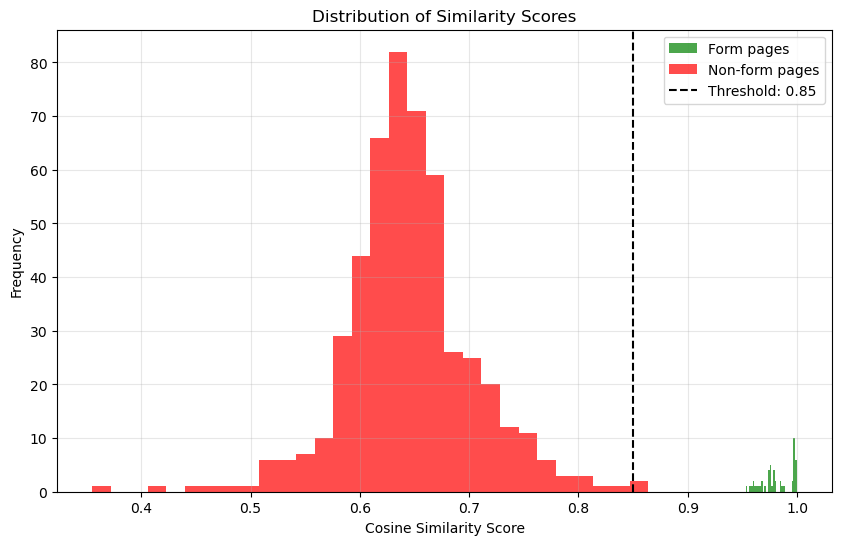


Suggested thresholds:
Gap-based threshold: 0.908
99th percentile threshold: 0.805

Selected optimal threshold: 0.908


In [95]:
# Plot score distributions
plt.figure(figsize=(10, 6))
plt.hist(positive_scores, bins=30, alpha=0.7, label='Form pages', color='green')
plt.hist(negative_scores, bins=30, alpha=0.7, label='Non-form pages', color='red')
plt.axvline(x=SIMILARITY_THRESHOLD, color='black', linestyle='--', 
            label=f'Threshold: {SIMILARITY_THRESHOLD}')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal threshold
# Simple approach: use value that separates distributions
gap_threshold = (positive_scores.min() + negative_scores.max()) / 2
percentile_threshold = np.percentile(negative_scores, 99)  # 99th percentile of negatives

print(f"\nSuggested thresholds:")
print(f"Gap-based threshold: {gap_threshold:.3f}")
print(f"99th percentile threshold: {percentile_threshold:.3f}")

# Update threshold
OPTIMAL_THRESHOLD = max(gap_threshold, percentile_threshold)
print(f"\nSelected optimal threshold: {OPTIMAL_THRESHOLD:.3f}")

## 10. Batch Processing Function

In [97]:
def process_document_folder(folder_path: Path,
                          model,
                          processor,
                          model_type: str,
                          reference_embeddings: np.ndarray,
                          reference_prototype: np.ndarray,
                          threshold: float,
                          output_file: str = 'zero_shot_results.csv',
                          max_files: Optional[int] = None,
                          use_prototype: bool = True) -> pd.DataFrame:
    """
    Process all PDFs in a folder using zero-shot classification
    """
    results = []
    pdf_files = list(folder_path.glob('*.pdf'))
    
    if max_files:
        pdf_files = pdf_files[:max_files]
    
    print(f"Processing {len(pdf_files)} PDF files...")
    
    for pdf_path in tqdm(pdf_files):
        result = classify_pdf_zero_shot(
            pdf_path, model, processor, model_type,
            reference_embeddings, reference_prototype,
            threshold=threshold,
            use_prototype=use_prototype
        )
        
        # Flatten results for CSV
        results.append({
            'filename': result['filename'],
            'contains_form': result['contains_form'],
            'form_pages': ','.join(map(str, result['form_pages'])),
            'num_form_pages': len(result['form_pages']),
            'total_pages': result.get('total_pages', 0),
            'max_similarity': result['max_similarity'],
            'error': result['error']
        })
    
    # Create DataFrame and save
    df_results = pd.DataFrame(results)
    df_results.to_csv(output_file, index=False)
    
    # Print summary
    print(f"\nResults saved to {output_file}")
    print(f"Total documents processed: {len(df_results)}")
    print(f"Documents with forms: {df_results['contains_form'].sum()}")
    print(f"Documents without forms: {(~df_results['contains_form']).sum()}")
    print(f"Processing errors: {df_results['error'].notna().sum()}")
    
    return df_results

## 11. Run Classification

In [99]:
# Test on a sample first
print("Testing on sample documents...")

# Create a test folder with mixed examples
test_results = process_document_folder(
    NON_EXAMPLES_PATH,
    model,
    processor,
    MODEL_TYPE,
    reference_embeddings,
    reference_prototype,
    threshold=OPTIMAL_THRESHOLD,
    output_file='zero_shot_test_results.csv',
    max_files=50,
    use_prototype=False  # Use full reference set for better accuracy
)

# Display sample results
print("\nSample results:")
print(test_results.head(10))

Testing on sample documents...
Processing 50 PDF files...


100%|███████████████████████████████████████████| 50/50 [04:57<00:00,  5.96s/it]


Results saved to zero_shot_test_results.csv
Total documents processed: 50
Documents with forms: 0
Documents without forms: 50
Processing errors: 0

Sample results:
                            filename  contains_form form_pages  \
0                      25581-000.pdf          False              
1  0000000000000000000062223-001.pdf          False              
2                       1197-000.pdf          False              
3                      67419-000.pdf          False              
4                     104473-000.pdf          False              
5        F1-10-FSSA-DDRS-495-000.pdf          False              
6         F1-8-FSSA-DMHA-564-003.pdf          False              
7                     104303-001.pdf          False              
8          F1-9-DCS-43810SAS-001.pdf          False              
9            F1-9-DCS-UNION2-000.pdf          False              

   num_form_pages  total_pages  max_similarity error  
0               0           25        0.782379  None 

## 12. Process Full Corpus

In [65]:
# Example code for processing the full 190k corpus
# Uncomment and modify the path as needed


CORPUS_PATH = BASE_PATH / 'data' / 'raw' / '_contracts'  # Adjust path

# Process in batches to save memory and allow interruption
batch_size = 1000
all_pdfs = list(CORPUS_PATH.glob('*.pdf'))
total_batches = (len(all_pdfs) + batch_size - 1) // batch_size

print(f"Processing {len(all_pdfs)} documents in {total_batches} batches...")

for batch_idx in range(total_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(all_pdfs))
    
    batch_pdfs = all_pdfs[start_idx:end_idx]
    batch_folder = Path('/tmp/batch_pdfs')  # Temporary folder
    batch_folder.mkdir(exist_ok=True)
    
    # Create symlinks for batch
    for pdf in batch_pdfs:
        (batch_folder / pdf.name).symlink_to(pdf)
    
    # Process batch
    batch_results = process_document_folder(
        batch_folder,
        model,
        processor,
        MODEL_TYPE,
        reference_embeddings,
        reference_prototype,
        threshold=OPTIMAL_THRESHOLD,
        output_file=f'zero_shot_results_batch_{batch_idx}.csv',
        use_prototype=False
    )
    
    # Clean up
    for link in batch_folder.glob('*.pdf'):
        link.unlink()
    
    print(f"Completed batch {batch_idx + 1}/{total_batches}")

# Combine all batch results
all_results = []
for batch_idx in range(total_batches):
    batch_df = pd.read_csv(f'zero_shot_results_batch_{batch_idx}.csv')
    all_results.append(batch_df)

final_results = pd.concat(all_results, ignore_index=True)
final_results.to_csv('zero_shot_results_complete.csv', index=False)
print(f"\nComplete results saved to zero_shot_results_complete.csv")


Processing 193450 documents in 194 batches...
Processing 1000 PDF files...


  2%|▉                                      | 23/1000 [02:08<1:30:48,  5.58s/it]


KeyboardInterrupt: 

## 13. Performance Comparison

In [ ]:
# Compare with trained model performance (if available)
print("\nPerformance Summary:")
print(f"Model type: {MODEL_TYPE}")
print(f"Reference examples: {len(reference_embeddings)}")
print(f"Optimal threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"\nProcessing speed: ~{len(test_results) / 60:.1f} documents per minute")

# Estimate time for full corpus
docs_per_minute = len(test_results) / 60  # Rough estimate
total_minutes = 190000 / docs_per_minute
print(f"\nEstimated time for 190k documents: {total_minutes/60:.1f} hours")

## Usage Instructions

### For production use:

1. **Model Selection**: Try different models (CLIP, DINOv2) to see which works best
2. **Threshold Tuning**: Use more examples/non-examples to fine-tune threshold
3. **Optimization**: 
   - Use GPU for faster processing
   - Process in parallel with multiprocessing
   - Cache embeddings for documents you process repeatedly

### Advantages over training:
- **Immediate deployment** - No training time
- **Easy updates** - Just add new reference examples
- **Interpretable** - Can inspect which references match
- **Flexible threshold** - Adjust precision/recall trade-off easily

### When to use training instead:
- If zero-shot accuracy is insufficient
- If you need to learn subtle patterns
- If you have many labeled examples
- If inference speed is critical (trained models can be faster)